In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/federicomercurio/mlfs-book


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
import os
import hopsworks
import json

project = hopsworks.login(engine="python")
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location_data = json.loads(location_str)

# Parse sensors array
sensors = location_data['sensors']
print(f"Loaded {len(sensors)} sensors")

# Get city and street from first sensor for display
city = sensors[0]['city']
street = sensors[0]['street']

2025-11-15 19:19:54,122 INFO: Initializing external client
2025-11-15 19:19:54,122 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-15 19:19:55,934 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272011
Loaded 4 sensors


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-15 19:19:58,795 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'relative_humidity_2m_mean'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features (including humidity) with air quality as the target",
    version=2,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object with UTC timezone
test_start = pd.to_datetime(start_date_test_data).tz_localize('UTC')

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.68s) 


In [9]:
# Create lag features for PM2.5 (previous 1, 2, and 3 days)
# Combine train and test data temporarily to create lags properly
df_combined = pd.concat([X_train, X_test], axis=0)
df_combined['pm25'] = pd.concat([y_train, y_test], axis=0)

# Convert date to datetime if it's not already
df_combined['date'] = pd.to_datetime(df_combined['date'])

# Sort by date to ensure proper lag calculation
df_combined = df_combined.sort_values('date').reset_index(drop=True)

# Create lag features
df_combined['pm25_lag1'] = df_combined['pm25'].shift(1)  # Yesterday
df_combined['pm25_lag2'] = df_combined['pm25'].shift(2)  # 2 days ago
df_combined['pm25_lag3'] = df_combined['pm25'].shift(3)  # 3 days ago

# Drop rows with NaN lags (first 3 rows)
df_combined = df_combined.dropna()

# Split back into train and test based on the test start date
train_mask = df_combined['date'] < test_start
X_train = df_combined[train_mask].drop(columns=['pm25'])
y_train = df_combined[train_mask][['pm25']].reset_index(drop=True)
X_test = df_combined[~train_mask].drop(columns=['pm25'])
y_test = df_combined[~train_mask][['pm25']].reset_index(drop=True)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {X_train.columns.tolist()}")

Training samples: 7045, Test samples: 789
Features: ['date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'relative_humidity_2m_mean', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
3,2017-10-07 00:00:00+00:00,14.941247,0.0,16.263872,327.604736,44.572155,8.00,9.00,13.00
4,2017-10-08 00:00:00+00:00,16.384996,0.0,12.904882,274.980957,62.386597,13.00,8.00,9.00
5,2017-10-09 00:00:00+00:00,14.882915,0.0,7.628263,65.616592,73.426956,8.00,13.00,8.00
6,2017-10-10 00:00:00+00:00,15.145415,0.0,7.421590,72.751175,72.687279,7.00,8.00,13.00
7,2017-10-11 00:00:00+00:00,15.762084,0.1,8.435069,50.767910,73.159782,12.00,7.00,8.00
...,...,...,...,...,...,...,...,...,...
7043,2025-04-29 00:00:00+00:00,18.457918,0.0,8.274128,299.845764,68.442642,6.75,7.20,5.40
7044,2025-04-30 00:00:00+00:00,19.580832,0.0,5.315336,166.417007,67.384552,5.80,6.75,7.20
7045,2025-04-30 00:00:00+00:00,19.580832,0.0,5.315336,166.417007,67.384552,5.50,5.80,6.75
7046,2025-04-30 00:00:00+00:00,19.580832,0.0,5.315336,166.417007,67.384552,9.93,5.50,5.80


In [11]:
# Drop date column for model training (keep weather features + humidity + lag features)
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

print(f"Training features shape: {X_features.shape}")
print(f"Features used: {X_features.columns.tolist()}")

Training features shape: (7045, 8)
Features used: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'relative_humidity_2m_mean', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']


In [12]:
y_train

,pm25
0,13.00
1,8.00
2,7.00
3,12.00
4,12.00
...,...
7040,5.80
7041,5.50
7042,9.93
7043,7.13


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our **8 features**:
- **Weather features (5)**: temperature, precipitation, wind speed, wind direction, **humidity**
- **Lag features (3)**: pm25_lag1 (yesterday), pm25_lag2 (2 days ago), pm25_lag3 (3 days ago)

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 60.97382
R squared: 0.6545907963612863


In [15]:
# Create dataframe with actual and predicted values
df = y_test.copy()
df['predicted_pm25'] = y_pred
df = df.reset_index(drop=True)

In [16]:
# Add dates from X_test and sort by date
df['date'] = X_test['date'].reset_index(drop=True)
df = df.sort_values(by=['date'])
print(f"Dataframe for plotting has {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head(5)

Dataframe for plotting has 789 rows
Date range: 2025-05-01 00:00:00+00:00 to 2025-11-15 00:00:00+00:00


,pm25,predicted_pm25,date
0,6.80,7.362999,2025-05-01 00:00:00+00:00
1,9.30,7.455488,2025-05-01 00:00:00+00:00
2,6.47,8.903665,2025-05-01 00:00:00+00:00
3,10.42,7.533598,2025-05-01 00:00:00+00:00
4,6.14,8.930961,2025-05-02 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

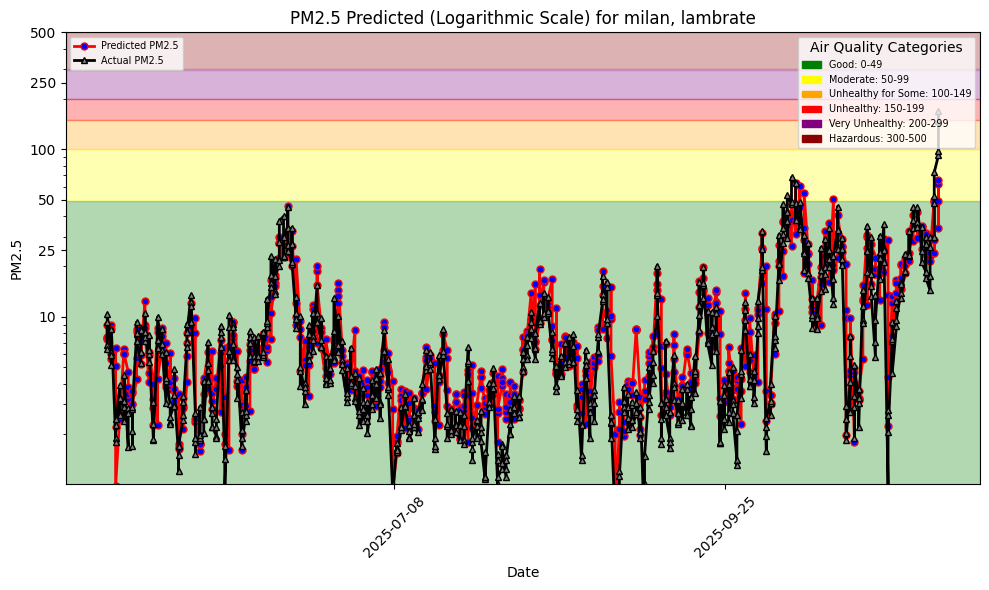

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

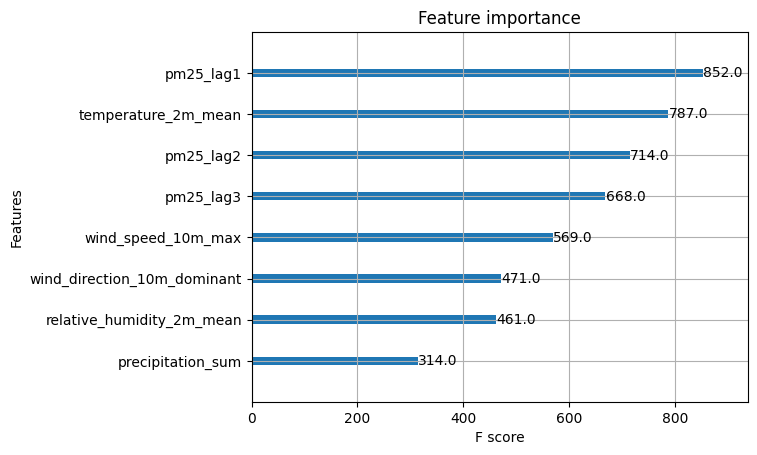

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/federicomercurio/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|        …

Uploading /Users/federicomercurio/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.p…

Uploading /Users/federicomercurio/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0…

Uploading /Users/federicomercurio/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0/658 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272011/models/air_quality_xgboost_model/8


Model(name: 'air_quality_xgboost_model', version: 8)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
